# Optimal location for pop-up clinics: improving health care accessibility#

In [1]:
!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
# !pip install shapely==1.6.3
!pip install plotly==4.12.0

  Using cached Shapely-1.6.3.tar.gz (223 kB)
    ERROR: Command errored out with exit status 1:
     command: /opt/venv/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-dtfsxo2o/shapely/setup.py'"'"'; __file__='"'"'/tmp/pip-install-dtfsxo2o/shapely/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-34286c5k
         cwd: /tmp/pip-install-dtfsxo2o/shapely/
    Complete output (11 lines):
    Failed `CDLL(libgeos_c.so.1)`
    Failed `CDLL(libgeos_c.so)`
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-install-dtfsxo2o/shapely/setup.py", line 80, in <module>
        from shapely._buildcfg import geos_version_string, geos_version, \
      File "/tmp/pip-install-dtfsxo2o/shapely/shapely/_buildcfg.py", line 167, in <module>
        fallback

## Healthcare Project ##

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Data

### AQI

In [3]:
# aqi for counties across the US in 2019
annual_aqi = pd.read_csv("annual_aqi_by_county_2019.csv")
annual_aqi["NAME"] = annual_aqi["County"] + " County, " + annual_aqi["State"]
annual_aqi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   State                                1052 non-null   object
 1   County                               1052 non-null   object
 2   Year                                 1052 non-null   int64 
 3   Days with AQI                        1052 non-null   int64 
 4   Good Days                            1052 non-null   int64 
 5   Moderate Days                        1052 non-null   int64 
 6   Unhealthy for Sensitive Groups Days  1052 non-null   int64 
 7   Unhealthy Days                       1052 non-null   int64 
 8   Very Unhealthy Days                  1052 non-null   int64 
 9   Hazardous Days                       1052 non-null   int64 
 10  Max AQI                              1052 non-null   int64 
 11  90th Percentile AQI                  1052 n

In [4]:
annual_aqi.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10,NAME
0,Alabama,Baldwin,2019,271,237,34,0,0,0,0,80,52,37,0,0,220,0,51,0,"Baldwin County, Alabama"
1,Alabama,Clay,2019,107,97,10,0,0,0,0,67,50,30,0,0,0,0,107,0,"Clay County, Alabama"
2,Alabama,Colbert,2019,263,252,11,0,0,0,0,61,47,37,0,0,228,0,35,0,"Colbert County, Alabama"
3,Alabama,DeKalb,2019,361,324,37,0,0,0,0,90,51,39,0,0,331,0,30,0,"DeKalb County, Alabama"
4,Alabama,Elmore,2019,228,208,20,0,0,0,0,100,50,39,0,0,228,0,0,0,"Elmore County, Alabama"


### Public health insurance

In [5]:
# public health insurance coverage for counties across US in 2019
public_ins_national_2019 = pd.read_csv("public_national_ins_2019.csv")
public_ins_national_2019.head()

,GEO_ID,NAME,K202703_001E,K202703_001M,K202703_002E,K202703_002M,K202703_003E,K202703_003M
0,id,Geographic Area Name,Estimate!!Total:,Margin of Error!!Total:,Estimate!!Total:!!With public coverage,Margin of Error!!Total:!!With public coverage,Estimate!!Total:!!No public coverage,Margin of Error!!Total:!!No public coverage
1,0500000US01001,"Autauga County, Alabama",55129,647,21307,2466,33822,2399
2,0500000US01003,"Baldwin County, Alabama",220911,1474,86564,6504,134347,6443
3,0500000US01005,"Barbour County, Alabama",21752,729,10528,1053,11224,1122
4,0500000US01007,"Bibb County, Alabama",21458,566,7244,1446,14214,1439


In [6]:
public_ins_national_2019 = pd.read_csv("public_national_ins_2019.csv").iloc[1:, :]
public_ins_national_2019 =  public_ins_national_2019.rename(columns = {"K202703_001E": "Estimate_Total", "K202703_001M": "Margin_of_Error_Total", "K202703_002E": "Estimate_Total_with_public_cov", "K202703_002M":  "Margin_of_Error_Total_with_public_cov", "K202703_003E": "Estimate_Total_no_public_cov", "K202703_003M": "Margin_of_Error_Total_no_public_cov"})
public_ins_national_2019["coverage"] = public_ins_national_2019["Estimate_Total_with_public_cov"].astype(int) / public_ins_national_2019["Estimate_Total"].astype(int)
public_ins_national_2019.head()

,GEO_ID,NAME,Estimate_Total,Margin_of_Error_Total,Estimate_Total_with_public_cov,Margin_of_Error_Total_with_public_cov,Estimate_Total_no_public_cov,Margin_of_Error_Total_no_public_cov,coverage
1,0500000US01001,"Autauga County, Alabama",55129,647,21307,2466,33822,2399,0.386493
2,0500000US01003,"Baldwin County, Alabama",220911,1474,86564,6504,134347,6443,0.391850
3,0500000US01005,"Barbour County, Alabama",21752,729,10528,1053,11224,1122,0.484001
4,0500000US01007,"Bibb County, Alabama",21458,566,7244,1446,14214,1439,0.337590
5,0500000US01009,"Blount County, Alabama",57378,356,20169,1789,37209,1796,0.351511


##### Merging AQI, Health insurance

In [7]:
merged_temp = public_ins_national_2019.merge(annual_aqi, on="NAME")
aqi_ins_coverage = merged_temp.sort_values(by="Median AQI", ascending=False)
aqi_ins_coverage[["NAME", "Median AQI", "coverage"]].head()

,NAME,Median AQI,coverage
67,"San Bernardino County, California",80,0.417208
64,"Riverside County, California",77,0.406822
53,"Los Angeles County, California",71,0.389905
50,"Kern County, California",67,0.493683
83,"Tulare County, California",66,0.546076


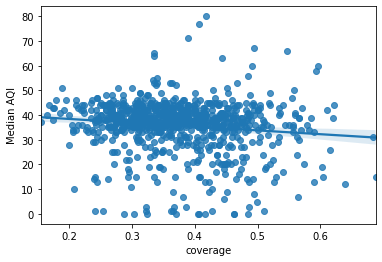

In [8]:
# association b/w Median AQI, public health insurance coverage 
median_aqi = aqi_ins_coverage["Median AQI"]
ins_coverage = aqi_ins_coverage["coverage"]

ax = sns.regplot(x="coverage", y="Median AQI", data=aqi_ins_coverage)

In [9]:
coverage_temp = np.asarray(ins_coverage)
aqi_temp = np.asarray(median_aqi)
x_std_units = (coverage_temp - np.mean(coverage_temp)) / np.std(coverage_temp)
y_std_units = (aqi_temp - np.mean(aqi_temp)) / np.std(aqi_temp)
r = np.corrcoef(x_std_units, y_std_units)[0][1]
r

-0.13061378746888053

We observe a weakly negative linear association between median AQI and public health insurance coverage rates. This AQI represents a physical or environmental factor of health. In regions with poorer air quality, they are slightly less likely to be covered with public health insurance.

### Economic characteristics

In [10]:
# various economic characterstics. so many columns tho O.o 
economic_characteristics = pd.read_csv("economic_characteristics.csv")
economic_characteristics.columns = economic_characteristics.iloc[0]
economic_characteristics = economic_characteristics.rename(columns={'Geographic Area Name':'NAME'})
economic_characteristics.head()

/opt/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2,3,5,6,8,9,11,12,14,15,17,18,20,21,23,24,26,27,29,30,32,33,35,36,38,39,41,42,44,45,47,48,50,51,53,54,56,57,59,60,62,63,65,66,68,70,71,73,74,76,77,79,80,82,83,85,86,87,89,90,92,93,95,96,98,99,101,102,104,105,107,108,110,111,113,114,116,117,119,120,122,123,125,126,128,129,131,132,134,135,137,138,140,141,143,144,146,147,149,150,152,153,155,156,158,159,161,162,164,165,167,168,170,171,173,174,176,177,179,180,182,183,185,186,188,189,191,192,194,195,197,198,200,201,206,207,212,213,215,216,218,219,221,222,224,225,227,228,230,231,233,234,236,237,239,240,242,243,245,246,248,249,251,252,254,255,257,258,260,261,263,264,266,267,269,270,272,273,275,276,278,279,281,282,284,285,287,288,290,291,293,294,296,297,299,300,302,303,305,306,308,309,311,312,314,315,317,318,320,321,323,324,326,327,329,330,332,333,335,336,338,339,341,342,344,345,347,348,350,351,353,354,356,357,359,360,362,363,365,366,368,369,374,

,id,NAME,2014-2018 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed,2009-2013 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed,2014-2018 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed,2009-2013 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed,2014-2018 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces,2009-2013 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces,...,Statistical Significance!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!Unrelated individuals 15 years and over,2014-2018 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over,2009-2013 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over,2014-2018 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,2009-2013 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,2014-2018 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force,2009-2013 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force
0,id,Geographic Area Name,2014-2018 Estimate!!EMPLOYMENT STATUS!!Populat...,2009-2013 Estimate!!EMPLOYMENT STATUS!!Populat...,Statistical Significance!!EMPLOYMENT STATUS!!P...,2014-2018 Estimate!!EMPLOYMENT STATUS!!Populat...,2009-2013 Estimate!!EMPLOYMENT STATUS!!Populat...,Statistical Significance!!EMPLOYMENT STATUS!!P...,2014-2018 Estimate!!EMPLOYMENT STATUS!!Populat...,2009-2013 Estimate!!EMPLOYMENT STATUS!!Populat...,...,Statistical Significance!!PERCENTAGE OF FAMILI...,2014-2018 Estimate!!EMPLOYMENT STATUS!!Populat...,2009-2013 Estimate!!EMPLOYMENT STATUS!!Populat...,Statistical Significance!!EMPLOYMENT STATUS!!P...,2014-2018 Estimate!!EMPLOYMENT STATUS!!Populat...,2009-2013 Estimate!!EMPLOYMENT STATUS!!Populat...,Statistical Significance!!EMPLOYMENT STATUS!!P...,2014-2018 Estimate!!EMPLOYMENT STATUS!!Populat...,2009-2013 Estimate!!EMPLOYMENT STATUS!!Populat...,Statistical Significance!!EMPLOYMENT STATUS!!P...
1,0500000US01001,"Autauga County, Alabama",55.6,56.7,NaN,2.5,5.9,*,1.3,1.6,...,NaN,43368,42226,*,59.3,64.2,*,58.1,62.6,*
2,0500000US01003,"Baldwin County, Alabama",55.7,54.8,NaN,2.6,5.6,*,0.2,0.2,...,NaN,167712,149574,*,58.5,60.6,*,58.3,60.4,*
3,0500000US01005,"Barbour County, Alabama",41.6,42.4,NaN,4.4,7.1,*,0.0,0.0,...,NaN,20948,22056,*,46.0,49.4,*,46.0,49.4,*
4,0500000US01007,"Bibb County, Alabama",43.8,43.6,NaN,3.6,6.1,*,0.0,0.0,...,NaN,18470,18405,NaN,47.4,49.7,NaN,47.4,49.6,NaN


In [11]:
def corr_coeff(x, y):
    x_su = (x - np.mean(x)) / np.std(x)
    y_su = (y - np.mean(y)) / np.std(y)
    r = np.corrcoef(x_std_units, y_std_units)[0][1]
    return r

In [12]:
economic_characteristics = economic_characteristics.rename(columns={"2014-2018 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed": "Employment"})
economic_characteristics["Employment"] = pd.to_numeric(economic_characteristics["Employment"], errors ='coerce')
economic_characteristics = economic_characteristics[~economic_characteristics['Employment'].isna()]
# ins_coverage_employment = ins_coverage_employment["NAME", "Employment"]
economic_characteristics.head()

,id,NAME,Employment,2009-2013 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed,2014-2018 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed,2009-2013 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed,2014-2018 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces,2009-2013 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces,...,Statistical Significance!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!Unrelated individuals 15 years and over,2014-2018 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over,2009-2013 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over,2014-2018 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,2009-2013 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,2014-2018 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force,2009-2013 Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force
1,0500000US01001,"Autauga County, Alabama",55.6,56.7,NaN,2.5,5.9,*,1.3,1.6,...,NaN,43368,42226,*,59.3,64.2,*,58.1,62.6,*
2,0500000US01003,"Baldwin County, Alabama",55.7,54.8,NaN,2.6,5.6,*,0.2,0.2,...,NaN,167712,149574,*,58.5,60.6,*,58.3,60.4,*
3,0500000US01005,"Barbour County, Alabama",41.6,42.4,NaN,4.4,7.1,*,0.0,0.0,...,NaN,20948,22056,*,46.0,49.4,*,46.0,49.4,*
4,0500000US01007,"Bibb County, Alabama",43.8,43.6,NaN,3.6,6.1,*,0.0,0.0,...,NaN,18470,18405,NaN,47.4,49.7,NaN,47.4,49.6,NaN
5,0500000US01009,"Blount County, Alabama",46.5,50.6,*,2.0,5.5,*,0.1,0.1,...,NaN,45915,45482,*,48.6,56.1,*,48.5,56.1,*


##### Merging Employment, Health insurance

In [13]:
ins_coverage_employment = public_ins_national_2019.merge(economic_characteristics, on="NAME")
ins_coverage_employment = ins_coverage_employment[['NAME', 'Employment', 'coverage']]
ins_coverage_employment.head()

,NAME,Employment,coverage
0,"Autauga County, Alabama",55.6,0.386493
1,"Baldwin County, Alabama",55.7,0.391850
2,"Barbour County, Alabama",41.6,0.484001
3,"Bibb County, Alabama",43.8,0.337590
4,"Blount County, Alabama",46.5,0.351511


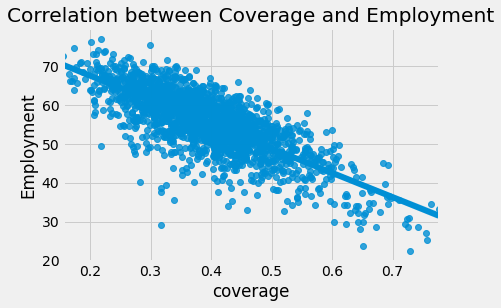

In [68]:
employment_estimate = ins_coverage_employment["Employment"]
ins_coverage = ins_coverage_employment["coverage"]

ax = sns.regplot(x="coverage", y="Employment", data=ins_coverage_employment)
plt.title("Correlation between Coverage and Employment");

In [15]:
ins_temp = np.asarray(ins_coverage)
employment_temp = np.asarray(employment_estimate)
x_std_units = (ins_temp - np.mean(ins_temp)) / np.std(ins_temp)
y_std_units = (employment_temp - np.mean(employment_temp)) / np.std(employment_temp)
r = np.corrcoef(x_std_units, y_std_units)[0][1]
r

-0.7612749660208625

We observe a strong negative correlation between employment rates and health insurance coverage rates per county. This fits our understanding of the data, however, because we focused on those covered by public health insurance programs, and areas with high employment rates are likely to be covered by private insurers.

### County data

In [16]:
county_data = pd.read_csv("county_data_abridged.csv")
county_data.head()

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4242,7.21,31850.0,25233.0


In [17]:
county_subset = county_data[["countyFIPS", "CountyName", "StateName", "#Hospitals", 'DiabetesPercentage', 'Smokers_Percentage', 'HeartDiseaseMortality', "TotalM.D.'s,TotNon-FedandFed2017"]]
print(county_subset.isna().sum())
print(county_subset.shape)
county_subset.head()

countyFIPS                            0
CountyName                            0
StateName                             0
#Hospitals                          103
DiabetesPercentage                   26
Smokers_Percentage                  103
HeartDiseaseMortality                42
TotalM.D.'s,TotNon-FedandFed2017     20
dtype: int64
(3244, 8)


,countyFIPS,CountyName,StateName,#Hospitals,DiabetesPercentage,Smokers_Percentage,HeartDiseaseMortality,"TotalM.D.'s,TotNon-FedandFed2017"
0,01001,Autauga,AL,1.0,9.9,18.081557,204.5,50.0
1,01003,Baldwin,AL,3.0,8.5,17.489033,183.2,536.0
2,01005,Barbour,AL,1.0,15.7,21.999985,220.4,12.0
3,01007,Bibb,AL,1.0,13.3,19.114200,225.5,16.0
4,01009,Blount,AL,1.0,14.9,19.208672,224.8,18.0


In [18]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [19]:
inverted_abbrev = dict(map(reversed, us_state_abbrev.items()))
full_state_names = county_subset['StateName'].apply(lambda x: inverted_abbrev.get(x))
county_subset['StateNameFull'] = full_state_names

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
county_subset.rename(columns={
    '#Hospitals':'Hospitals',
    "TotalM.D.'s,TotNon-FedandFed2017":'NumDoctors'
},
inplace=True,
)

county_subset['NAME'] = county_subset['CountyName']+ ' County, ' + county_subset['StateNameFull']
county_subset.drop(['CountyName', 'StateName', 'StateNameFull'], axis=1, inplace=True)
county_subset.head()

/opt/venv/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/venv/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,countyFIPS,Hospitals,DiabetesPercentage,Smokers_Percentage,HeartDiseaseMortality,NumDoctors,NAME
0,01001,1.0,9.9,18.081557,204.5,50.0,"Autauga County, Alabama"
1,01003,3.0,8.5,17.489033,183.2,536.0,"Baldwin County, Alabama"
2,01005,1.0,15.7,21.999985,220.4,12.0,"Barbour County, Alabama"
3,01007,1.0,13.3,19.114200,225.5,16.0,"Bibb County, Alabama"
4,01009,1.0,14.9,19.208672,224.8,18.0,"Blount County, Alabama"


### Final dataset merge

In [21]:
aqi_ins_coverage.head()

,GEO_ID,NAME,Estimate_Total,Margin_of_Error_Total,Estimate_Total_with_public_cov,Margin_of_Error_Total_with_public_cov,Estimate_Total_no_public_cov,Margin_of_Error_Total_no_public_cov,coverage,State,...,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
67,0500000US06071,"San Bernardino County, California",2135343,3512,890882,20427,1244461,19968,0.417208,California,...,0,213,169,80,0,16,246,0,96,7
64,0500000US06065,"Riverside County, California",2445952,2327,995066,19166,1450886,18941,0.406822,California,...,0,185,147,77,0,0,247,0,70,48
53,0500000US06037,"Los Angeles County, California",9964081,3335,3885047,30770,6079034,31474,0.389905,California,...,0,201,136,71,0,36,197,0,124,8
50,0500000US06029,"Kern County, California",873613,2473,431288,15415,442325,15150,0.493683,California,...,1,548,122,67,0,2,260,0,73,30
83,0500000US06107,"Tulare County, California",461513,852,252021,11823,209492,11656,0.546076,California,...,0,280,122,66,0,2,242,0,98,23


In [22]:
ins_coverage_employment.head()

,NAME,Employment,coverage
0,"Autauga County, Alabama",55.6,0.386493
1,"Baldwin County, Alabama",55.7,0.391850
2,"Barbour County, Alabama",41.6,0.484001
3,"Bibb County, Alabama",43.8,0.337590
4,"Blount County, Alabama",46.5,0.351511


In [23]:
merge1 = pd.merge(aqi_ins_coverage, ins_coverage_employment, how='inner', on=['NAME', 'coverage'])
print(merge1.shape)
merge1.head()

(838, 29)


,GEO_ID,NAME,Estimate_Total,Margin_of_Error_Total,Estimate_Total_with_public_cov,Margin_of_Error_Total_with_public_cov,Estimate_Total_no_public_cov,Margin_of_Error_Total_no_public_cov,coverage,State,...,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10,Employment
0,0500000US06071,"San Bernardino County, California",2135343,3512,890882,20427,1244461,19968,0.417208,California,...,213,169,80,0,16,246,0,96,7,54.8
1,0500000US06065,"Riverside County, California",2445952,2327,995066,19166,1450886,18941,0.406822,California,...,185,147,77,0,0,247,0,70,48,54.7
2,0500000US06037,"Los Angeles County, California",9964081,3335,3885047,30770,6079034,31474,0.389905,California,...,201,136,71,0,36,197,0,124,8,60.0
3,0500000US06029,"Kern County, California",873613,2473,431288,15415,442325,15150,0.493683,California,...,548,122,67,0,2,260,0,73,30,52.0
4,0500000US06107,"Tulare County, California",461513,852,252021,11823,209492,11656,0.546076,California,...,280,122,66,0,2,242,0,98,23,53.3


In [24]:
merge2 = pd.merge(merge1, county_subset, how='inner', on=['NAME'])
print(merge2.shape)
merge2.head()

(827, 35)


,GEO_ID,NAME,Estimate_Total,Margin_of_Error_Total,Estimate_Total_with_public_cov,Margin_of_Error_Total_with_public_cov,Estimate_Total_no_public_cov,Margin_of_Error_Total_no_public_cov,coverage,State,...,Days SO2,Days PM2.5,Days PM10,Employment,countyFIPS,Hospitals,DiabetesPercentage,Smokers_Percentage,HeartDiseaseMortality,NumDoctors
0,0500000US06071,"San Bernardino County, California",2135343,3512,890882,20427,1244461,19968,0.417208,California,...,0,96,7,54.8,06071,18.0,9.4,12.628277,181.4,4831.0
1,0500000US06065,"Riverside County, California",2445952,2327,995066,19166,1450886,18941,0.406822,California,...,0,70,48,54.7,06065,16.0,8.7,12.499944,167.8,4007.0
2,0500000US06037,"Los Angeles County, California",9964081,3335,3885047,30770,6079034,31474,0.389905,California,...,0,124,8,60.0,06037,76.0,8.1,10.847678,150.8,36517.0
3,0500000US06029,"Kern County, California",873613,2473,431288,15415,442325,15150,0.493683,California,...,0,73,30,52.0,06029,10.0,9.5,15.314177,199.7,1345.0
4,0500000US06107,"Tulare County, California",461513,852,252021,11823,209492,11656,0.546076,California,...,0,98,23,53.3,06107,4.0,9.3,13.799712,189.8,649.0


In [58]:
features = ['NAME', 'coverage','Median AQI', 'Employment', 'Hospitals', 'DiabetesPercentage',
             'Smokers_Percentage', 'HeartDiseaseMortality', 'NumDoctors']
data = merge2[features]

final_data = data.set_index('NAME')
final_data

,coverage,Median AQI,Employment,Hospitals,DiabetesPercentage,Smokers_Percentage,HeartDiseaseMortality,NumDoctors
NAME,,,,,,,,
"San Bernardino County, California",0.417208,80,54.8,18.0,9.4,12.628277,181.4,4831.0
"Riverside County, California",0.406822,77,54.7,16.0,8.7,12.499944,167.8,4007.0
"Los Angeles County, California",0.389905,71,60.0,76.0,8.1,10.847678,150.8,36517.0
"Kern County, California",0.493683,67,52.0,10.0,9.5,15.314177,199.7,1345.0
"Tulare County, California",0.546076,66,53.3,4.0,9.3,13.799712,189.8,649.0
...,...,...,...,...,...,...,...,...
"Botetourt County, Virginia",0.287744,0,57.6,0.0,9.7,14.067544,168.2,50.0
"Robertson County, Texas",0.406360,0,56.0,0.0,13.8,14.721785,213.1,2.0
"Oneida County, Wisconsin",0.370370,0,55.7,1.0,6.5,14.620806,175.2,142.0


In [26]:
data.to_csv('merged_data.csv')

# Exploratory Data Analysis

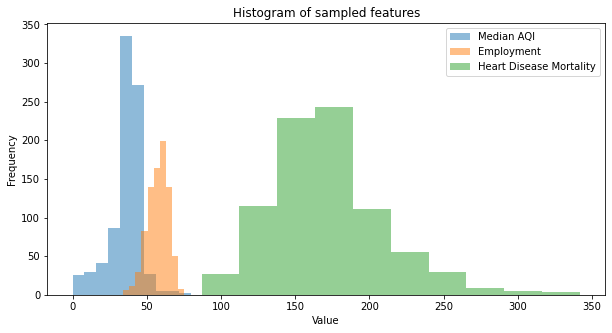

In [27]:
plt.figure(figsize = (10, 5))
plt.hist(data['Median AQI'], alpha=0.5, label="Median AQI")
plt.hist(data['Employment'], alpha=0.5, label="Employment")
plt.hist(data['HeartDiseaseMortality'], alpha=0.5, label="Heart Disease Mortality")
plt.legend()
plt.title("Histogram of sampled features")
plt.xlabel("Value")
plt.ylabel("Frequency");

We compare the distributions of our sampled features e.g., Median AQI (physical/environmental), Employment (economic), and Heart Disease Mortality (medical).

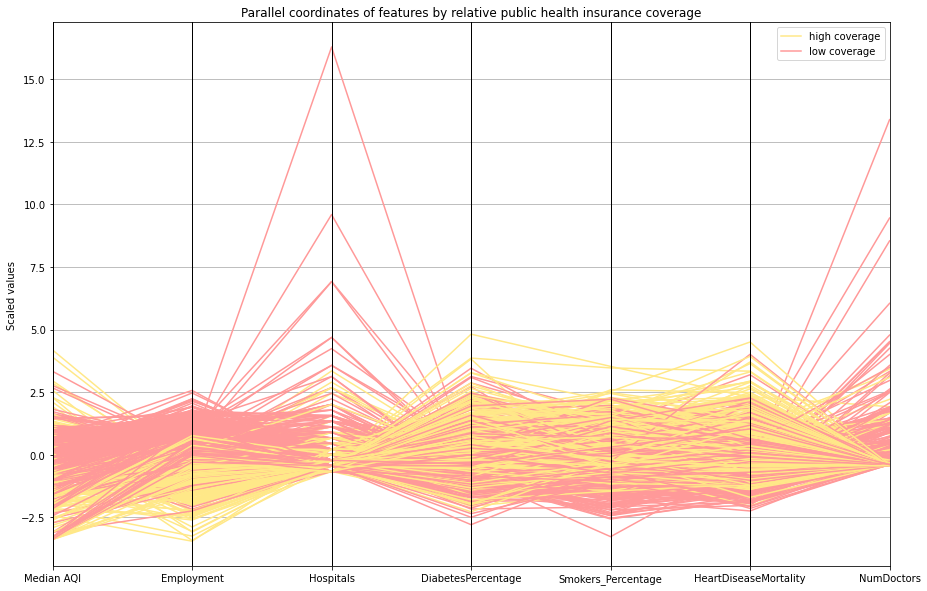

In [28]:
def coverage(x):
    if x < 0.4:
        return 'low coverage'
    return 'high coverage'

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

subset_df = data.drop(columns = ['NAME', 'coverage'])
scaled_df = ss.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns = subset_df.columns)
scaled_df['relative coverage'] = data['coverage'].apply(coverage).reset_index(drop = True)

# plot parallel coordinates
from pandas.plotting import parallel_coordinates
plt.figure(figsize = (15,10))
pc = parallel_coordinates(scaled_df, 'relative coverage', color = ('#FFE888', '#FF9999'))
plt.title("Parallel coordinates of features by relative public health insurance coverage")
plt.ylabel("Scaled values");

In [29]:
FIPS_data = pd.merge(data, county_subset[['countyFIPS', 'NAME']], on = 'NAME')
FIPS_data = FIPS_data.rename(columns = {'countyFIPS' : 'FIPS'})
FIPS_data

,NAME,coverage,Median AQI,Employment,Hospitals,DiabetesPercentage,Smokers_Percentage,HeartDiseaseMortality,NumDoctors,FIPS
0,"San Bernardino County, California",0.417208,80,54.8,18.0,9.4,12.628277,181.4,4831.0,06071
1,"Riverside County, California",0.406822,77,54.7,16.0,8.7,12.499944,167.8,4007.0,06065
2,"Los Angeles County, California",0.389905,71,60.0,76.0,8.1,10.847678,150.8,36517.0,06037
3,"Kern County, California",0.493683,67,52.0,10.0,9.5,15.314177,199.7,1345.0,06029
4,"Tulare County, California",0.546076,66,53.3,4.0,9.3,13.799712,189.8,649.0,06107
...,...,...,...,...,...,...,...,...,...,...
822,"Botetourt County, Virginia",0.287744,0,57.6,0.0,9.7,14.067544,168.2,50.0,51023
823,"Robertson County, Texas",0.406360,0,56.0,0.0,13.8,14.721785,213.1,2.0,48395
824,"Oneida County, Wisconsin",0.370370,0,55.7,1.0,6.5,14.620806,175.2,142.0,55085
825,"Seneca County, New York",0.462007,0,54.5,0.0,11.0,15.834345,154.3,22.0,36099


# Model building

In [31]:
data.head()

,NAME,coverage,Median AQI,Employment,Hospitals,DiabetesPercentage,Smokers_Percentage,HeartDiseaseMortality,NumDoctors
0,"San Bernardino County, California",0.417208,80,54.8,18.0,9.4,12.628277,181.4,4831.0
1,"Riverside County, California",0.406822,77,54.7,16.0,8.7,12.499944,167.8,4007.0
2,"Los Angeles County, California",0.389905,71,60.0,76.0,8.1,10.847678,150.8,36517.0
3,"Kern County, California",0.493683,67,52.0,10.0,9.5,15.314177,199.7,1345.0
4,"Tulare County, California",0.546076,66,53.3,4.0,9.3,13.799712,189.8,649.0


In [32]:
data.columns

Index(['NAME', 'coverage', 'Median AQI', 'Employment', 'Hospitals',
       'DiabetesPercentage', 'Smokers_Percentage', 'HeartDiseaseMortality',
       'NumDoctors'],
      dtype='object')

We first conduct principal component analysis (PCA) dataset in order to reduce the dimensionality. This will tell us the most relevant features of our dataset, and it is useful for K-means clustering which will indicate to us the common features of counties that require more public health coverage. We assume that counties which have lower rates of public coverage are in greater need of pop-up clinics for the uninsured.at

In [33]:
def normalize_features(feature):
    return (feature - np.mean(feature)) / np.std(feature)

In [34]:
# normalize features
X = data[['coverage', 'Employment','Hospitals', 'DiabetesPercentage','Median AQI']]

for feature in X.columns:
    X[feature] = normalize_features(X[feature])

X.head()

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,coverage,Employment,Hospitals,DiabetesPercentage,Median AQI
0,0.489561,-0.422446,3.349046,-0.105355,4.184764
1,0.373001,-0.436980,2.903225,-0.362480,3.901216
2,0.183159,0.333342,16.277846,-0.582873,3.334119
3,1.347796,-0.829408,1.565763,-0.068623,2.956055
4,1.935765,-0.640462,0.228301,-0.142087,2.861539


In [35]:
# PCA to reduce dimensionality to two principle components
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)
X_pca

original shape:    (827, 5)
transformed shape: (827, 2)


array([[-1.32410876,  5.17364942],
       [-1.31017083,  4.62072261],
       [-5.26893882, 12.6609232 ],
       ...,
       [ 0.5618987 , -2.75541368],
       [ 2.00684115, -2.32638337],
       [ 0.11292216, -2.70774018]])

### K-means clustering

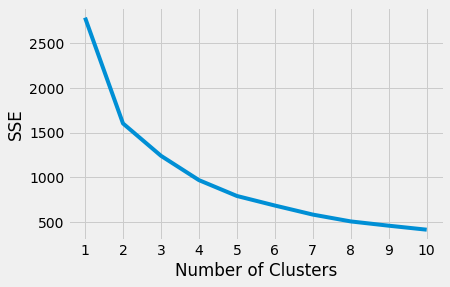

In [36]:
# elbow method
kmeans_kwargs = {
    "init": "random",
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_pca)
    sse.append(kmeans.inertia_)


plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show();

In [37]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

4

According to our elbow test, the optimal number of clusters is 4.

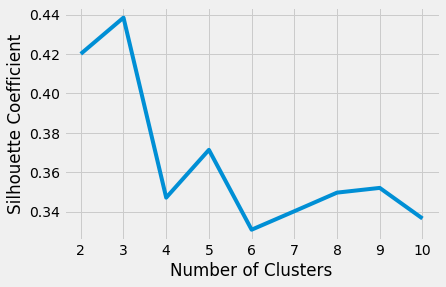

In [38]:
silhouette_coeffs_train = []

for i in np.arange(2, 11): # try num clusters
  kmeans = KMeans(n_clusters=i, random_state=42)
  kmeans.fit(X_pca)
  s1 = silhouette_score(X_pca, kmeans.labels_)
  silhouette_coeffs_train.append(s1)
  
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coeffs_train)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show();

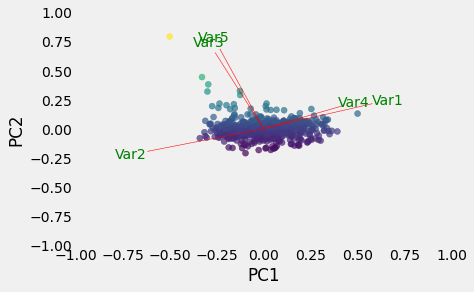

array([[ 0.57553275, -0.61356086, -0.25539896,  0.41690883, -0.23078892],
       [ 0.21281132, -0.19327562,  0.64728407,  0.19405008,  0.67876636]])

In [39]:
k=4 # try optimal num clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_pca)
s1 = silhouette_score(X_pca, kmeans.labels_)
  
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys*scaley, c=ys, alpha=0.7) 
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')


plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

myplot(X_pca[:, 0:2], np.transpose(pca.components_[0:2, :]))
plt.show()
pca.components_

In [40]:
pca.explained_variance_ratio_

array([0.42817203, 0.24538214])

The most important features are 1, 2, and 4, according to the PCA analysis. These correspond to the variables Coverage, Employment, and DiabetesPercentage.

In [41]:
# features 1, 2, 4 = coverage, employment, DiabetesPercentage are most important 
print(abs( pca.components_ ))

[[0.57553275 0.61356086 0.25539896 0.41690883 0.23078892]
 [0.21281132 0.19327562 0.64728407 0.19405008 0.67876636]]


In [42]:
cluster_dict = dict(zip(X.index, kmeans.labels_))

In [43]:
# Cluster analysis 
X['Cluster'] = kmeans.labels_
X.groupby('Cluster').agg(np.median)

# Based on aggregate feature values for each cluster, cluster 0 should be given highest 
# priority for setting up pop-up check ups because it has the lowest employemnt, 
# lowest number of hospitals, highest DiabetesPercentage, and worst AQI.


/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,coverage,Employment,Hospitals,DiabetesPercentage,Median AQI
Cluster,,,,,
0,1.124220,-1.221837,-0.440430,0.776217,-0.068458
1,-0.427511,0.347876,3.571956,-0.197185,1.680089
2,-0.972447,0.929251,-0.217520,-0.656337,0.215090
3,0.115920,-0.015483,-0.217520,0.041574,0.215090


### Interpret Model Results

In [44]:
X_copy = X.copy()
X_copy['NAME'] = data['NAME']
X_copy.reset_index(inplace=True)

In [60]:
import plotly.figure_factory as ff

df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/laucnty16.csv')
df_sample['State FIPS Code'] = df_sample['State FIPS Code'].apply(lambda x: str(x).zfill(2))
df_sample['County FIPS Code'] = df_sample['County FIPS Code'].apply(lambda x: str(x).zfill(3))
df_sample['FIPS'] = df_sample['State FIPS Code'] + df_sample['County FIPS Code']

FIPS_data = pd.merge(data, county_subset[['countyFIPS', 'NAME']], on = 'NAME')
FIPS_data = FIPS_data.rename(columns = {'countyFIPS' : 'FIPS'})
FIPS_data = pd.merge(FIPS_data, df_sample[['FIPS']], on = 'FIPS')
FIPS_data = pd.merge(FIPS_data, X_copy, on='NAME')

# colorscale = ["#f7fbff","#0e4d64","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
#               "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
#               "#08519c","#0b4083","#08306b"]

colorscale = ["#0A2F51", "#d1768F", '#CC5500', "#137177", '#6A0DAD', "#1D9A6C", "#39A96B", 
              "#56B870", "#74C67A", '#99D492', '#BFE1B0','#DEEDCF']

endpts = list(np.linspace(1, 12, len(colorscale) - 1))
fips = FIPS_data['FIPS'].tolist()
values = FIPS_data['Cluster'].tolist()



fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=False,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='USA by Cluster',
    legend_title='Cluster number'
)

fig.layout.template = None
fig.show();

### linear regression model

We also use the data collected to make predictions about the public insurance coverage for each county.

In [46]:
# linear regression to predict uncovered public insurance population
from sklearn import linear_model as lm
y = 1-data['coverage']
X = data[['Employment','Hospitals', 'DiabetesPercentage', 'Smokers_Percentage','HeartDiseaseMortality', 'NumDoctors', 'Median AQI']]

nrows = data.shape[0]
print(nrows)
shuffled = np.random.choice(range(nrows), size=nrows, replace=False)

# 0.8, 0.2 split
train_end = int(len(shuffled)*0.8)
test_start = train_end+1
test_end = nrows

train_ii = shuffled[:train_end]
test_ii = shuffled[test_start:]

train_X, train_y = X.iloc[train_ii], y.iloc[train_ii]
test_X, test_y = X.iloc[test_ii], y.iloc[test_ii]

827


In [47]:
from sklearn import linear_model as lm
from sklearn import metrics


model = lm.LinearRegression()
model.fit(train_X,train_y)
train_preds = model.predict(train_X)

# evaluation metrics
y_pred = train_preds
y_true = train_y

print('TRAINING')
print('mean absolute error: ' + str(metrics.mean_absolute_error(y_true, y_pred)))
print('root mean squared error: ' + str(np.sqrt(metrics.mean_squared_error(y_true, y_pred))))


test_preds = model.predict(test_X)
y_pred = test_preds
y_true = test_y

print('TESTING')
print('mean absolute error: ' + str(metrics.mean_absolute_error(y_true, y_pred)))
print('root mean squared error: ' + str(np.sqrt(metrics.mean_squared_error(y_true, y_pred))))

TRAINING
mean absolute error: 0.04401366971681687
root mean squared error: 0.05612276793709166
TESTING
mean absolute error: 0.04296872340468815
root mean squared error: 0.05549178762335231


Testing RMSE is 0.0572 and MAE is 0.0445. Also, Training and testing metrics are not highly disparate, indicating the model is not overfitting and has performed to its best ability. 